In [23]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [24]:
data_merge = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\ver_2_1_merge_data.csv")
data_merge

,base_date,emd_cd,korean_resd,korean_work,korean_visit,long_term_frgn_resd,long_term_frgn_work,long_term_frgn_visit,short_term_frgn_visit,resident_fe_korean,resident_fe_frgn,resident_m_korean,resident_m_frgn,card_cnt_home,card_amt_home,card_cnt_out,card_amt_out,waste_cnt,waste_amt
0,2019-11-30,50110250,1.271267e+07,1.446387e+06,5.875401e+06,811872.3300,95124.9987,374564.3540,129161.4006,10377,1353,11023,2396,301.620000,1.176953e+07,235.281250,7.540087e+06,620,2279550
1,2019-12-31,50110250,1.328514e+07,1.231725e+06,5.683448e+06,786204.8681,76167.6125,406752.6260,122124.6609,10354,1332,11011,2383,295.567742,1.175619e+07,239.472393,7.592077e+06,8178,31493650
2,2020-01-31,50110250,1.322148e+07,1.009434e+06,6.466703e+06,820791.3342,105162.4135,482137.5505,112758.3034,10369,1328,11004,2375,290.387097,1.201056e+07,226.043478,7.374075e+06,13042,49632850
3,2020-02-29,50110250,1.269528e+07,9.268498e+05,4.635128e+06,778132.5491,90134.7711,469304.6248,60252.7989,10341,1328,10985,2367,275.468966,1.023490e+07,224.297297,7.316381e+06,12264,46197050
4,2020-03-31,50110250,1.389778e+07,9.606578e+05,5.133711e+06,841049.3554,103988.5098,610456.5714,29661.4429,10310,1322,10970,2340,290.870968,1.066116e+07,232.694805,7.287016e+06,14316,52561750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,2.215681e+06,4.711373e+05,3.850127e+06,131090.2409,21260.3645,88065.1221,280.6159,1904,137,2013,119,74.918519,3.094460e+06,53.826087,1.723436e+06,4563,15566250
1630,2021-03-31,50130620,2.345047e+06,5.526314e+05,4.191678e+06,135195.9186,24214.5837,94044.3054,1475.8404,1918,137,2007,116,73.897959,3.175512e+06,60.849624,1.906193e+06,4920,17300600
1631,2021-04-30,50130620,2.282004e+06,5.918539e+05,4.644853e+06,137049.8002,24437.3744,104790.3736,1283.0997,1904,135,2004,118,74.993151,2.940971e+06,61.398438,1.939595e+06,5256,17646850
1632,2021-05-31,50130620,2.387585e+06,6.403488e+05,5.165064e+06,148574.6128,30121.6614,114091.6036,1212.2652,1910,135,2021,112,80.437908,3.820713e+06,57.283688,1.826895e+06,6346,19494750


xgboost 모델링

In [25]:
X_features = data_merge.loc[:, ['korean_resd', 'korean_work', 'korean_visit', 
                      'long_term_frgn_resd', 'long_term_frgn_work', 'long_term_frgn_visit', 
                      'short_term_frgn_visit', 
                      'resident_fe_korean', 'resident_fe_frgn', 'resident_m_korean', 'resident_m_frgn', 
                      'card_cnt_home', 'card_amt_home', 'card_cnt_out', 'card_amt_out', 
                      'waste_cnt']]
y_label = data_merge.loc[:, 'waste_amt']

In [26]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(1307, 16) (327, 16)


In [27]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [28]:
# max_depth = 3, 학습률은 0.1, 목적함수(objective)는 reg:linear(회귀)
# 오류함수의 평가성능지표는 rmse
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 7,
         'eta' : 0.1, 
         'objective' : 'reg:linear',
         'eval_metric' : 'rmsle',
         'early_stoppings' : 100 }
num_rounds = 1000

In [29]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[13:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmsle:2.31534	eval-rmsle:2.31339
[1]	train-rmsle:1.67253	eval-rmsle:1.66643
[2]	train-rmsle:1.31622	eval-rmsle:1.31235
[3]	train-rmsle:1.07865	eval-rmsle:1.07744
[4]	train-rmsle:0.90403	eval-rmsle:0.90152
[5]	train-rmsle:0.76815	eval-rmsle:0.76804
[6]	train-rmsle:0.66113	eval-rmsle:0.66248
[7]	train-rmsle:0.57368	eval-rmsle:0.57473
[8]	train-rmsle:0.50124	eval-rmsle:0.50389
[9]	train-rmsle:0.44031	eval-rmsle:0.4445

[172]	train-rmsle:0.01840	eval-rmsle:0.09093
[173]	train-rmsle:0.01837	eval-rmsle:0.09091
[174]	train-rmsle:0.01786	eval-rmsle:0.09088
[175]	train-rmsle:0.01773	eval-rmsle:0.09089
[176]	train-rmsle:0.01765	eval-rmsle:0.09089
[177]	train-rmsle:0.01757	eval-rmsle:0.09086
[178]	train-rmsle:0.01749	eval-rmsle:0.09081
[179]	train-rmsle:0.01740	eval-rmsle:0.09079
[180]	train-rmsle:0.01720	eval-rmsle:0.09082
[181]	train-rmsle:0.01715	eval-rmsle:0.09081
[182]	train-rmsle:0.01714	eval-rmsle:0.09082
[183]	train-rmsle:0.01703	eval-rmsle:0.09082
[184]	train-rmsle:0.01682	eval-rmsle:0.09079
[185]	train-rmsle:0.01677	eval-rmsle:0.09076
[186]	train-rmsle:0.01671	eval-rmsle:0.09072
[187]	train-rmsle:0.01654	eval-rmsle:0.09070
[188]	train-rmsle:0.01652	eval-rmsle:0.09071
[189]	train-rmsle:0.01653	eval-rmsle:0.09075
[190]	train-rmsle:0.01651	eval-rmsle:0.09073
[191]	train-rmsle:0.01637	eval-rmsle:0.09069
[192]	train-rmsle:0.01632	eval-rmsle:0.09069
[193]	train-rmsle:0.01631	eval-rmsle:0.09071
[194]	trai

[354]	train-rmsle:0.00644	eval-rmsle:0.08993
[355]	train-rmsle:0.00643	eval-rmsle:0.08993
[356]	train-rmsle:0.00638	eval-rmsle:0.08994
[357]	train-rmsle:0.00637	eval-rmsle:0.08994
[358]	train-rmsle:0.00637	eval-rmsle:0.08995
[359]	train-rmsle:0.00635	eval-rmsle:0.08995
[360]	train-rmsle:0.00634	eval-rmsle:0.08994
[361]	train-rmsle:0.00619	eval-rmsle:0.08993
[362]	train-rmsle:0.00618	eval-rmsle:0.08994
[363]	train-rmsle:0.00604	eval-rmsle:0.08994
[364]	train-rmsle:0.00602	eval-rmsle:0.08994
[365]	train-rmsle:0.00600	eval-rmsle:0.08994
[366]	train-rmsle:0.00597	eval-rmsle:0.08993
[367]	train-rmsle:0.00596	eval-rmsle:0.08994
[368]	train-rmsle:0.00595	eval-rmsle:0.08994
[369]	train-rmsle:0.00593	eval-rmsle:0.08993
[370]	train-rmsle:0.00592	eval-rmsle:0.08994
[371]	train-rmsle:0.00591	eval-rmsle:0.08996
[372]	train-rmsle:0.00590	eval-rmsle:0.08996
[373]	train-rmsle:0.00588	eval-rmsle:0.08996
[374]	train-rmsle:0.00556	eval-rmsle:0.08993
[375]	train-rmsle:0.00556	eval-rmsle:0.08993
[376]	trai

[536]	train-rmsle:0.00176	eval-rmsle:0.08964
[537]	train-rmsle:0.00176	eval-rmsle:0.08964
[538]	train-rmsle:0.00175	eval-rmsle:0.08964
[539]	train-rmsle:0.00175	eval-rmsle:0.08964
[540]	train-rmsle:0.00174	eval-rmsle:0.08964
[541]	train-rmsle:0.00174	eval-rmsle:0.08965
[542]	train-rmsle:0.00173	eval-rmsle:0.08964
[543]	train-rmsle:0.00173	eval-rmsle:0.08964
[544]	train-rmsle:0.00169	eval-rmsle:0.08964
[545]	train-rmsle:0.00168	eval-rmsle:0.08964
[546]	train-rmsle:0.00167	eval-rmsle:0.08964
[547]	train-rmsle:0.00166	eval-rmsle:0.08964
[548]	train-rmsle:0.00166	eval-rmsle:0.08964
[549]	train-rmsle:0.00165	eval-rmsle:0.08964
[550]	train-rmsle:0.00165	eval-rmsle:0.08964
[551]	train-rmsle:0.00164	eval-rmsle:0.08964
[552]	train-rmsle:0.00161	eval-rmsle:0.08963
[553]	train-rmsle:0.00161	eval-rmsle:0.08963
[554]	train-rmsle:0.00157	eval-rmsle:0.08963
[555]	train-rmsle:0.00156	eval-rmsle:0.08963
[556]	train-rmsle:0.00150	eval-rmsle:0.08963
[557]	train-rmsle:0.00150	eval-rmsle:0.08963
[558]	trai

[718]	train-rmsle:0.00057	eval-rmsle:0.08960
[719]	train-rmsle:0.00057	eval-rmsle:0.08960
[720]	train-rmsle:0.00056	eval-rmsle:0.08960
[721]	train-rmsle:0.00056	eval-rmsle:0.08960
[722]	train-rmsle:0.00056	eval-rmsle:0.08960
[723]	train-rmsle:0.00056	eval-rmsle:0.08960
[724]	train-rmsle:0.00056	eval-rmsle:0.08960
[725]	train-rmsle:0.00055	eval-rmsle:0.08960
[726]	train-rmsle:0.00055	eval-rmsle:0.08960
[727]	train-rmsle:0.00055	eval-rmsle:0.08960
[728]	train-rmsle:0.00053	eval-rmsle:0.08960
[729]	train-rmsle:0.00053	eval-rmsle:0.08960
[730]	train-rmsle:0.00053	eval-rmsle:0.08960
[731]	train-rmsle:0.00052	eval-rmsle:0.08960
[732]	train-rmsle:0.00052	eval-rmsle:0.08960
[733]	train-rmsle:0.00052	eval-rmsle:0.08960
[734]	train-rmsle:0.00052	eval-rmsle:0.08960
[735]	train-rmsle:0.00051	eval-rmsle:0.08960
[736]	train-rmsle:0.00051	eval-rmsle:0.08960
[737]	train-rmsle:0.00051	eval-rmsle:0.08960
[738]	train-rmsle:0.00051	eval-rmsle:0.08960
[739]	train-rmsle:0.00051	eval-rmsle:0.08960
[740]	trai

[901]	train-rmsle:0.00018	eval-rmsle:0.08959
[902]	train-rmsle:0.00017	eval-rmsle:0.08959
[903]	train-rmsle:0.00017	eval-rmsle:0.08959
[904]	train-rmsle:0.00017	eval-rmsle:0.08959
[905]	train-rmsle:0.00017	eval-rmsle:0.08959
[906]	train-rmsle:0.00017	eval-rmsle:0.08959
[907]	train-rmsle:0.00017	eval-rmsle:0.08959
[908]	train-rmsle:0.00017	eval-rmsle:0.08959
[909]	train-rmsle:0.00017	eval-rmsle:0.08959
[910]	train-rmsle:0.00017	eval-rmsle:0.08959
[911]	train-rmsle:0.00017	eval-rmsle:0.08959
[912]	train-rmsle:0.00016	eval-rmsle:0.08959
[913]	train-rmsle:0.00016	eval-rmsle:0.08959
[914]	train-rmsle:0.00016	eval-rmsle:0.08959
[915]	train-rmsle:0.00016	eval-rmsle:0.08959
[916]	train-rmsle:0.00016	eval-rmsle:0.08959
[917]	train-rmsle:0.00016	eval-rmsle:0.08959
[918]	train-rmsle:0.00016	eval-rmsle:0.08959
[919]	train-rmsle:0.00016	eval-rmsle:0.08959
[920]	train-rmsle:0.00016	eval-rmsle:0.08959
[921]	train-rmsle:0.00016	eval-rmsle:0.08959
[922]	train-rmsle:0.00016	eval-rmsle:0.08959
[923]	trai

In [30]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[1.1948468e+07 1.8735880e+08 2.6954448e+07 2.2355250e+08 4.2436128e+07
 3.5114576e+07 6.0112124e+07 4.1694076e+07 1.0460005e+08 9.9676288e+07]
예측값 10개만 표시:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [31]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [32]:
get_clf_eval(y_test, preds)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

feature importance 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

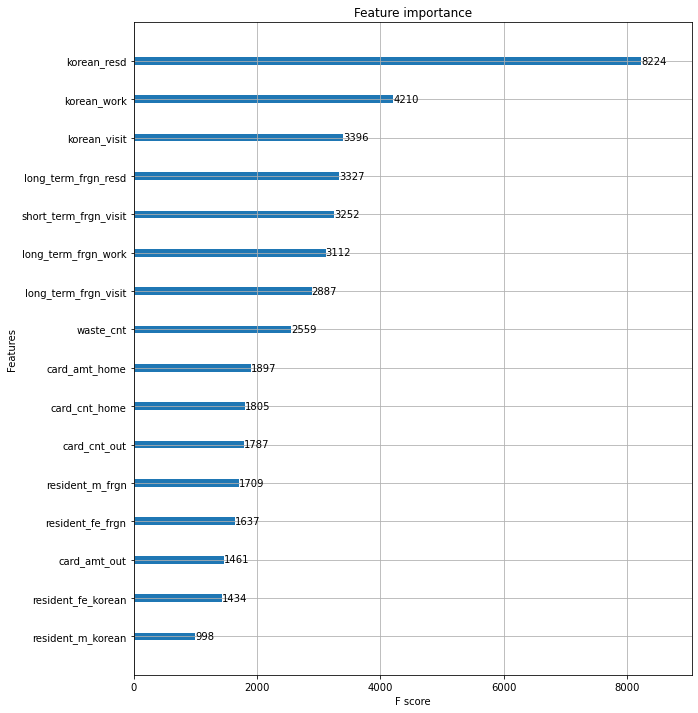

In [33]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)